# Data Exploration

![image](./images/johan-van-wambeke-_2VioFUgQVg-unsplash.jpg)

Import the relevant packages and data.

In [1]:
#import packages
import folium
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,HashingVectorizer
from nltk.probability import FreqDist
from nltk.tokenize import regexp_tokenize,word_tokenize,RegexpTokenizer
from nltk import pos_tag
from nltk.corpus import wordnet
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB,GaussianNB

In [2]:
#read in data
df = pd.read_csv('./data/Tweets.csv')

In [3]:
#shape
df.shape

(14640, 15)

In [4]:
#column names
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [5]:
#data types by columns and null value overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [6]:
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [ ]:
#function to remove -008 from data column
def fix_date(dateobject):
    date = str(dateobject)
    return date[0:19]

Based on a previous analysis, class imbalance appears to be present.

In [7]:
#drop irrelevant columns
# df.drop(['tweet_id','negativereason_gold','airline_sentiment_gold','negativereason','airline_sentiment_confidence','negativereason_confidence'],axis=1,inplace=True)

In [8]:
target = df['airline_sentiment']
X_train,X_test,y_train,y_test = train_test_split(df,target,test_size = .2,random_state=23)
X_train['tweet_created'] = X_train['tweet_created'].map(lambda x:fix_date(x))
X_train['tweet_created'] = pd.to_datetime(X_train['tweet_created'],infer_datetime_format=True)


NameError: name 'fix_date' is not defined

In [31]:
#fix data type

df['tweet_created'] = pd.to_datetime(df['tweet_created'].map(lambda x:fix_date(x)),infer_datetime_format=True)

In [11]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45,NaN,Pacific Time (US & Canada)


In [12]:
#function to format coordinate string into list of coordinates
def get_coords(mystr):
    if mystr != None:
        mapdict = {'[': None, ']':None,",":None,}
        mappingtbl = mystr.maketrans(mapdict)

        newstr = mystr.translate(mappingtbl)
        new = newstr.split()
        gps = []
        for item in new:
            gps.append(float(item))
        return gps

In [13]:
#if the tweet was created in a month other than february, let us know
months = df['tweet_created'].map(lambda x:x.month).to_list()
for month in months:
    if month != 2:
        print('Not February')

In [14]:
#which days in february?
days = df['tweet_created'].map(lambda x:x.day).to_list()
set(days)

{16, 17, 18, 19, 20, 21, 22, 23, 24}

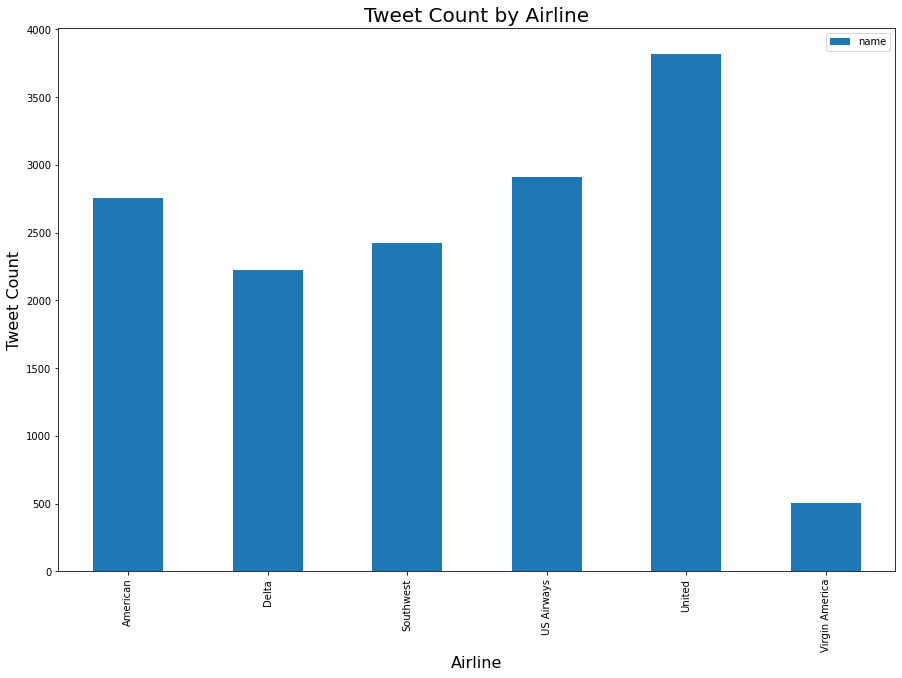

In [15]:
#tweet distribution by airline
df[['airline','name']].groupby(by='airline').count().plot(kind='bar',figsize=(15,10))
plt.title('Tweet Count by Airline',fontdict={'size':20,'color':'black'})
plt.xlabel('Airline',fontdict={'size':16,'color':'black'})
plt.ylabel('Tweet Count',fontdict={'size':16,'color':'black'});

In [16]:
df['airline'].unique()

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways',
       'American'], dtype=object)

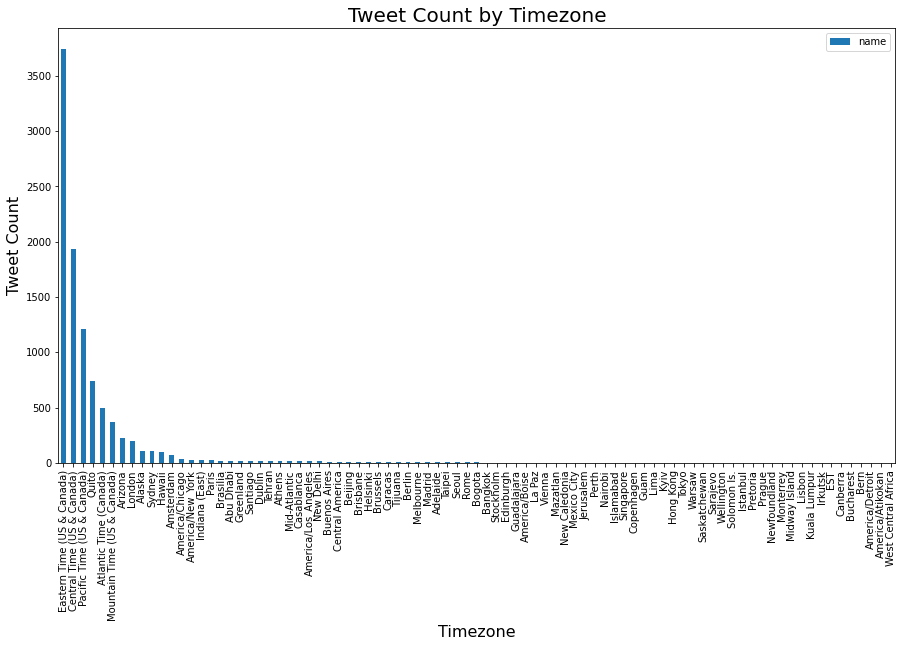

In [17]:
#tweet distribution by timezone
tweet_counts = df[['user_timezone','name']].groupby(by='user_timezone').count()
tweet_counts.sort_values('name',ascending=False).plot(kind='bar',figsize=(15,8))
plt.title('Tweet Count by Timezone',fontdict={'size':20,'color':'black'})
plt.xlabel('Timezone',fontdict={'size':16,'color':'black'})
plt.ylabel('Tweet Count',fontdict={'size':16,'color':'black'});

In [30]:
#for tweets with gps coords, view on map
fig = folium.Figure(width=1000,height=700)
m=folium.Map(location=[35.78286995214768, -81.31681409412731],zoom_start=4)
has_latlong = df[['name','airline','tweet_coord']].copy(deep=True)
has_latlong.dropna(inplace=True)
has_latlong['tweet_coord'] = has_latlong['tweet_coord'].map(lambda x:get_coords(str(x)))

def assign_colors(airline):
    airlines = ['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways','American'] 
    colors = ['pink','red','green','blue','white','yellow']
    which_color = dict(zip(airlines,colors))
    return which_color[airline]

has_latlong['marker_color'] = has_latlong['airline'].map(lambda x: assign_colors(x))

for index, row in has_latlong.iterrows():
    folium.CircleMarker(location=row['tweet_coord'],radius=5,fill = True,fillOpacity=0.2,popup=row['airline'],tooltip='Click for info',color=row['marker_color']).add_to(m)
fig.add_child(m)